In [ ]:
!pip install statsforecast

In [ ]:
import sys
import pandas as pd
import numpy as np
import statsforecast
from statsforecast.models import ARIMA, SeasonalNaive
from statsforecast import StatsForecast
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilsforecast.losses import mase

In [ ]:
# Versões
print("Versões:")
print('Python -> %s' % sys.version)
print('Pandas -> %s' % pd.__version__)
print('Numpy -> %s' % np.__version__)
print('Statsforecast -> %s' % statsforecast.__version__)

Versões:
Python -> 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
Pandas -> 2.2.2
Numpy -> 1.26.4
Statsforecast -> 2.0.1


In [ ]:
ROOT = "/content/drive/MyDrive/dl-project"
DATA_FILE = f"{ROOT}/data/riser_pq_uni.csv"
SEED = 78

rename_dict = {
    "Time (sec)": "time",
    "Pressure (bar) @x_{99}=56.9453": "pressure_1",
    "Pressure (bar) @x_{105}=60.4141": "pressure_2",
    "Pressure (bar) @x_{109}=62.7266": "pressure_3",
    "Pressure (bar) @x_{114}=65.6172": "pressure_4",
    "Pressure (bar) @x_{119}=68.5078": "pressure_5",
    "Pressure (bar) @x_{124}=71.3984": "pressure_6",
    "Pressure (bar) @x_{128}=73.7109": "pressure_7",
    "Gas mass rate (kg/sec)": "gas_flow_rate",
    "Liquid mass rate (kg/sec)": "liquid_flow_rate",
}

TRAINING_STEPS = 1500
TIME = ['time']
FEATURES = [
    'pressure_1',
    'pressure_2',
    'pressure_3',
    'pressure_4',
    'pressure_5',
    'pressure_6',
    'pressure_7'
]
TARGETS = ['gas_flow_rate','liquid_flow_rate']

In [ ]:
data = pd.read_csv(DATA_FILE).rename(columns=rename_dict)

data_ = (
    data[TIME + FEATURES + TARGETS]
    .assign(time=np.floor(data['time']).astype(int))
    .groupby(['time'])[FEATURES + TARGETS].mean()
    .reset_index()
    .sort_values(by='time')
)

data_.head()

,time,pressure_1,pressure_2,pressure_3,pressure_4,pressure_5,pressure_6,pressure_7,gas_flow_rate,liquid_flow_rate
0,0,2.066200,2.038975,1.849575,1.618100,1.394075,1.179475,1.014875,0.021678,55.518500
1,1,2.069233,2.047900,1.862067,1.629967,1.404933,1.188800,1.025567,0.011846,26.402000
2,2,2.064700,2.041100,1.857833,1.625100,1.399833,1.183967,1.019900,0.026317,51.498667
3,3,2.060525,2.036700,1.856600,1.624475,1.399750,1.184250,1.020350,0.035752,62.201250
4,4,2.057700,2.034233,1.856233,1.624233,1.399533,1.184133,1.020267,0.041210,68.307667


In [ ]:
# Requerimento do Nixtla
data_['ds'] = data_['time']
data_['y'] = data_['liquid_flow_rate']
data_['unique_id'] = 'SlugFlow'

In [ ]:
train_data = data_.loc[data_['ds'] <= TRAINING_STEPS, ['unique_id', 'ds', 'y']]
test_data = data_.loc[data_['ds'] > TRAINING_STEPS, ['unique_id', 'ds', 'y']]

<Figure size 1200x300 with 0 Axes>

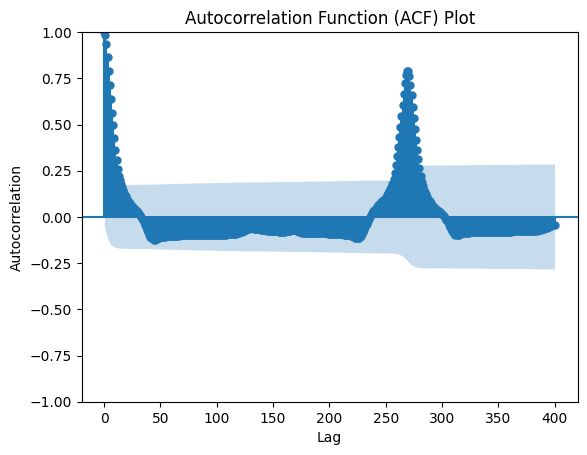

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plot_acf(train_data['y'], lags=400)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show();

Analysis using find_peaks shows the first significant seasonal peak is at lag: 269


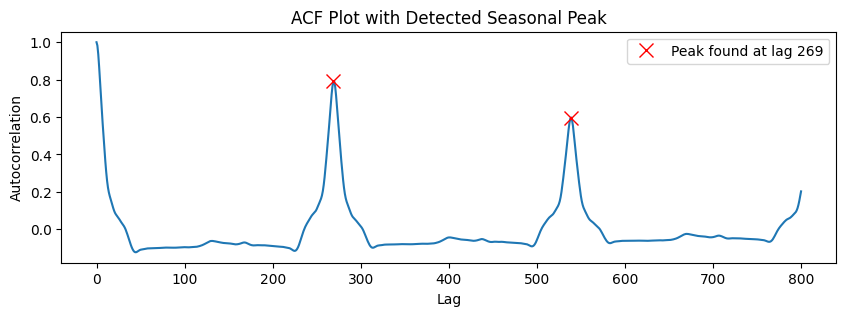

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

# --- Calcula valores do ACF ---
acf_values = acf(train_data['y'], nlags=800, fft=True)

# --- Encontrar os picos nos dados da ACF ---
# Usamos um parâmetro de `distância` para garantir que não encontraremos apenas picos na queda inicial.
# Uma distância de 100 significa que os picos devem estar separados por pelo menos 100 defasagens (lags).
# Um parâmetro de `altura` garante que apenas picos significativos sejam encontrados.
peaks, _ = find_peaks(acf_values, height=0.2, distance=100)

# O primeiro pico encontrado após o lag 0 é o período sasonal.
if len(peaks) > 0:
    seasonal_period = peaks[0]
    print(f"Analysis using find_peaks shows the first significant seasonal peak is at lag: {seasonal_period}")
else:
    print("No significant seasonal peak was found with the current settings.")

plt.figure(figsize=(10, 3))
plt.plot(acf_values)
plt.plot(peaks, acf_values[peaks], "x", color='red', markersize=10, label=f'Peak found at lag {seasonal_period}')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF Plot with Detected Seasonal Peak')
plt.legend()
plt.show()

In [ ]:
ground_truth = test_data.copy()
ground_truth

,unique_id,ds,y
1501,SlugFlow,1501,91.592333
1502,SlugFlow,1502,96.149750
1503,SlugFlow,1503,101.114667
1504,SlugFlow,1504,105.843333
1505,SlugFlow,1505,111.156667
...,...,...,...
2996,SlugFlow,2996,22.713000
2997,SlugFlow,2997,22.696038
2998,SlugFlow,2998,22.470111
2999,SlugFlow,2999,22.205667


### Seasonal Naive

In [ ]:
seasonality = 269
models = [
    SeasonalNaive(season_length=seasonality)
]

sf = StatsForecast(
    models=models,
    freq=1,
)

In [ ]:
sf.fit(
    df=train_data
)

StatsForecast(models=[SeasonalNaive])

In [ ]:
h = len(test_data)
seasonalnaive_output = sf.predict(
    h=h,
)

seasonalnaive_output

,unique_id,ds,SeasonalNaive
0,SlugFlow,1501,93.352667
1,SlugFlow,1502,98.063000
2,SlugFlow,1503,103.206667
3,SlugFlow,1504,108.133333
4,SlugFlow,1505,112.710000
...,...,...,...
1495,SlugFlow,2996,22.556667
1496,SlugFlow,2997,22.197615
1497,SlugFlow,2998,22.014407
1498,SlugFlow,2999,22.228852


In [ ]:
seasonalnaive_results = pd.merge(
    ground_truth,
    seasonalnaive_output,
    on=['unique_id', 'ds'],
    how='left'
)

seasonalnaive_results

,unique_id,ds,y,SeasonalNaive
0,SlugFlow,1501,91.592333,93.352667
1,SlugFlow,1502,96.149750,98.063000
2,SlugFlow,1503,101.114667,103.206667
3,SlugFlow,1504,105.843333,108.133333
4,SlugFlow,1505,111.156667,112.710000
...,...,...,...,...
1495,SlugFlow,2996,22.713000,22.556667
1496,SlugFlow,2997,22.696038,22.197615
1497,SlugFlow,2998,22.470111,22.014407
1498,SlugFlow,2999,22.205667,22.228852


In [ ]:
file_name = 'seasonalnaive_results.csv'
seasonalnaive_results.to_csv(f"{ROOT}/results/{file_name}", index=False)

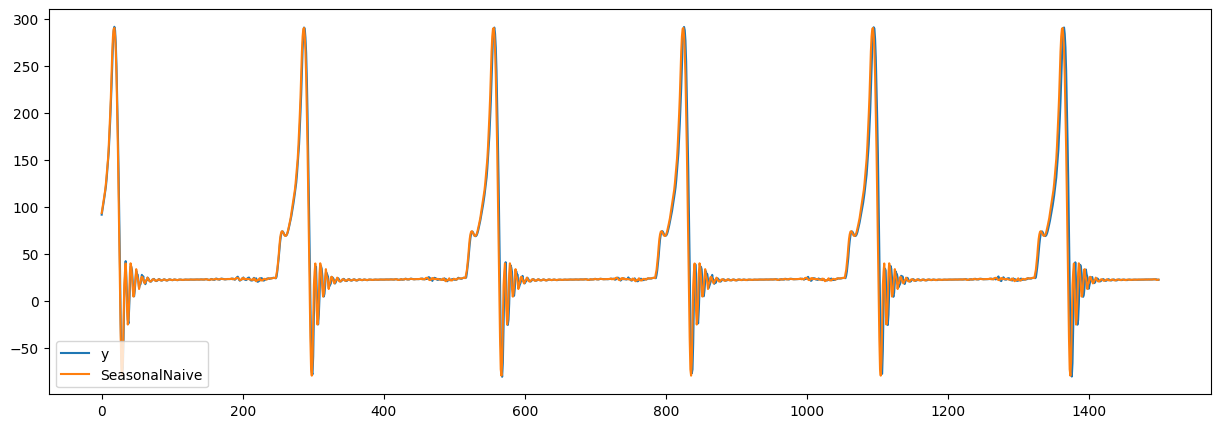

In [ ]:
seasonalnaive_results[['y', 'SeasonalNaive']].plot(figsize=(15, 5));

In [ ]:
y_true = seasonalnaive_results['y']
y_pred = seasonalnaive_results['SeasonalNaive']

print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

RMSE: 14.290595343417104
MAE: 5.255087316908136


In [ ]:
y_hist = train_data['y']
y_true = test_data['y']
y_pred = seasonalnaive_results['SeasonalNaive']
seasonal_period = 269

In [ ]:
mase_score = mase(
    df=seasonalnaive_results,
    models=['SeasonalNaive'],
    seasonality=seasonal_period,
    train_df=train_data,
    id_col='unique_id',
    target_col='y',
)
mase_score

,unique_id,SeasonalNaive
0,SlugFlow,1.743394


### ARIMA

In [ ]:
models = [
    ARIMA(
        season_length=269,
        order=(1,0,1),
        seasonal_order=(1,1,1)
    ),
]

sf = StatsForecast(
    models=models,
    freq=1,
)



In [ ]:
sf.fit(
    df=train_data
)

StatsForecast(models=[ARIMA])

In [ ]:
h = len(test_data)
forecasts_output = sf.predict(
    h=h,
)

forecasts_output

,unique_id,ds,ARIMA
0,SlugFlow,1501,91.989373
1,SlugFlow,1502,97.234312
2,SlugFlow,1503,102.785304
3,SlugFlow,1504,107.788384
4,SlugFlow,1505,111.815023
...,...,...,...
1495,SlugFlow,2996,22.530776
1496,SlugFlow,2997,22.168600
1497,SlugFlow,2998,21.811731
1498,SlugFlow,2999,22.167762


In [ ]:
ground_truth = test_data.copy()
ground_truth

,unique_id,ds,y
1501,SlugFlow,1501,91.592333
1502,SlugFlow,1502,96.149750
1503,SlugFlow,1503,101.114667
1504,SlugFlow,1504,105.843333
1505,SlugFlow,1505,111.156667
...,...,...,...
2996,SlugFlow,2996,22.713000
2997,SlugFlow,2997,22.696038
2998,SlugFlow,2998,22.470111
2999,SlugFlow,2999,22.205667


In [ ]:
arima_results = pd.merge(
    ground_truth,
    forecasts_output,
    on=['unique_id', 'ds'],
    how='left'
)

arima_results

,unique_id,ds,y,ARIMA
0,SlugFlow,1501,91.592333,91.989373
1,SlugFlow,1502,96.149750,97.234312
2,SlugFlow,1503,101.114667,102.785304
3,SlugFlow,1504,105.843333,107.788384
4,SlugFlow,1505,111.156667,111.815023
...,...,...,...,...
1495,SlugFlow,2996,22.713000,22.530776
1496,SlugFlow,2997,22.696038,22.168600
1497,SlugFlow,2998,22.470111,21.811731
1498,SlugFlow,2999,22.205667,22.167762


In [ ]:
file_name = 'arima_results.csv'
arima_results.to_csv(f"{ROOT}/results/{file_name}", index=False)

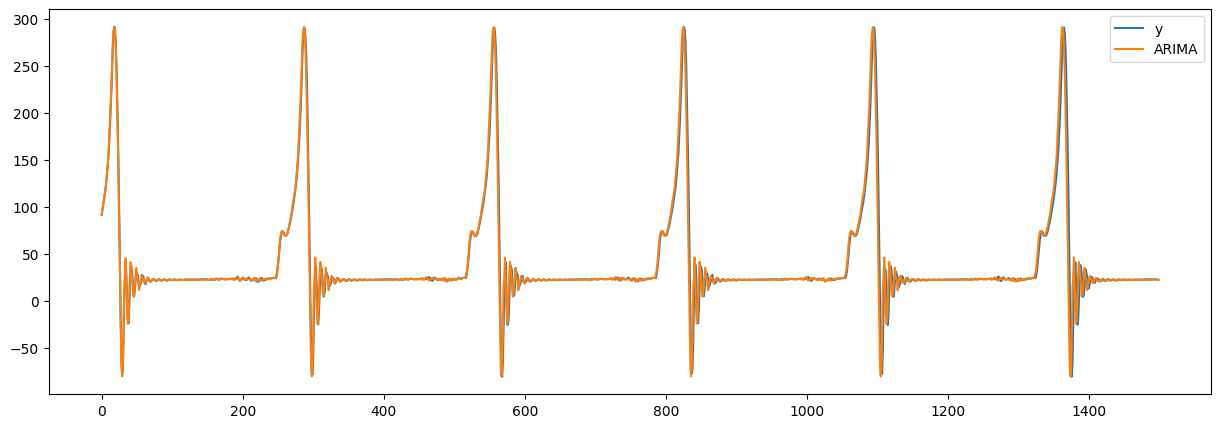

In [ ]:
arima_results[['y', 'ARIMA']].plot(figsize=(15, 5));

In [ ]:
y_true = arima_results['y']
y_pred = arima_results['ARIMA']

print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}")
print(f"MAE: {mean_absolute_error(y_true, y_pred)}")

RMSE: 12.885218135699679
MAE: 4.70053699310892


In [ ]:
y_hist = train_data['y']
y_true = test_data['y']
y_pred = arima_results['ARIMA']
seasonal_period = 269

In [ ]:
mase_score = mase(
    df=arima_results,
    models=['ARIMA'],
    seasonality=seasonal_period,
    train_df=train_data,
    id_col='unique_id',
    target_col='y',
)
print(f"MASE: {mase_score}")

MASE:   unique_id    ARIMA
0  SlugFlow  1.55942


In [ ]:
mase_score

,unique_id,ARIMA
0,SlugFlow,1.55942
